# Betting Simulation

To assess the applied merits of the pre-developed goal prediction model, this notebook simulates how it would perform in the betting market. To do this, data is sourced from https://www.football-data.co.ukcontaining which contains historical odds for the over/under 2.5 goals market covering the relevant matches.

##1. Dependencies

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data
matches_pred = pd.read_csv("/content/drive/My Drive/Goal_Prediction_Model/data/model_predictions.csv")
odds_df = pd.DataFrame()
for f in os.listdir("/content/drive/My Drive/Goal_Prediction_Model/data/odds_data/"):
    df = pd.read_csv(f"/content/drive/My Drive/Goal_Prediction_Model/data/odds_data/{f}")
    df = df[["Div", "Date", "Time", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "Avg>2.5", "Avg<2.5", "Max>2.5", "Max<2.5"]]
    odds_df = pd.concat([odds_df, df], ignore_index=True)

##2. Cleaning Odds Data

The data from football-odds.co.uk is not formatted exactly like my predictions data set so some cleaning is needed. Implied probabilities are also calculated from the market odds. The average market odds are used (multiple types are provided by football-data.co.uk) to give a fair and realistic reflection of model performance.

In [3]:
# Calculate implied probabilities for over/under 2.5 goals
odds_df['implied_over'] = 1 / (odds_df['Avg>2.5'])
odds_df['implied_under'] = 1 / (odds_df['Avg<2.5'])

# Make team names consistent
odds_df["HomeTeam"] = odds_df["HomeTeam"].replace({'Bristol Rvs': 'Bristol'})
odds_df["AwayTeam"] = odds_df["AwayTeam"].replace({'Bristol Rvs': 'Bristol'})
team_name_map = {}
for short_name in odds_df["HomeTeam"].unique():
    for long_name in matches_pred["home_team"].unique():
        if short_name in long_name:
            team_name_map[short_name] = long_name
            break

# Renaming columns
odds_df['home_team'] = odds_df['HomeTeam'].map(team_name_map)
odds_df['away_team'] = odds_df['AwayTeam'].map(team_name_map)
odds_df.rename(columns={'Date': 'start'}, inplace=True)

# Reformatting date columns so the tables can be merged
odds_df['start'] = pd.to_datetime(odds_df['start'], format='%d/%m/%Y', errors="coerce")
matches_pred['start'] = pd.to_datetime(matches_pred['start'], errors="coerce")
matches_pred['start'] = matches_pred['start'].dt.date
matches_pred['start'] = pd.to_datetime(matches_pred['start'], errors="coerce")
betting_df = matches_pred.merge(odds_df[['start', 'home_team', 'away_team', 'Avg>2.5', 'Avg<2.5', 'implied_over', 'implied_under']], how='left')
betting_df.dropna(inplace=True)
print(len(betting_df))
betting_df.head()

1223


,Unnamed: 0,match_id,start,season,home_team,home_pred,home_goals,home_match_num,season_match_number,away_team,away_pred,away_goals,away_match_num,total_mu,total_goals,log_loss,Avg>2.5,Avg<2.5,implied_over,implied_under
0,0,116585,2024-08-09,2025,Barnsley,1.602909,1,0,1,Mansfield Town,1.393527,2,0,2.996436,3,1.495925,1.73,2.06,0.578035,0.485437
1,1,116583,2024-08-09,2025,Chesterfield,1.670284,1,0,1,Swindon Town,1.926301,1,0,3.596585,2,1.729763,1.55,2.37,0.645161,0.421941
2,2,116689,2024-08-10,2025,Fleetwood Town,1.141583,1,0,1,Grimsby Town,1.019832,0,0,2.161416,1,1.390652,1.87,1.88,0.534759,0.531915
3,3,116693,2024-08-10,2025,Tranmere Rovers,1.696009,0,0,1,Notts County,1.348223,0,0,3.044232,0,3.044232,1.60,2.25,0.625000,0.444444
4,4,116677,2024-08-10,2025,Harrogate Town,2.193013,0,0,1,Bromley,1.165504,2,0,3.358517,2,1.628665,1.89,1.87,0.529101,0.534759


##3. Selecting Value Bets

The process of selecting 'value' bets requires calculating the implied probabilities of the market odds and comparing them to the probabilities calculated by the model. Where the model assigns a greater probability of over/under 2.5 goals than the market odds, there is a positive long-run expected return to placing a bet (assuming the model is good). These cases represent value bets.

In [4]:
# Two functions to calculate over/under 2.5 goal probabilities from predictive model
def under_proba_vec(home_mu, away_mu):
    total_mu = home_mu + away_mu
    under = poisson.cdf(2, total_mu)
    return under
def over_proba_vec(home_mu, away_mu):
    total_mu = home_mu + away_mu
    over = 1 -poisson.cdf(2, total_mu)
    return over

# Implementing the functions to get the model's predictions
betting_df['model_over'] = over_proba_vec(betting_df['home_pred'], betting_df['away_pred'])
betting_df['model_under'] = under_proba_vec(betting_df['home_pred'], betting_df['away_pred'])

# Highlighting positive EV bets
betting_df['over_bet'] = False
betting_df['under_bet'] = False
over_bet = betting_df['implied_over'] < betting_df['model_over']
under_bet = betting_df['implied_under'] < betting_df['model_under']
betting_df.loc[over_bet, "over_bet"] = True
betting_df.loc[under_bet, "under_bet"] = True


##4. Level Stakes Simulation

Having selected the model's value bets, the potential retruns are calculated using a simple level stakes strategy which places a unit bet in all cases where the model identifies value. There are more complex strategies (e.g. Kelly, fractional Kelly), which determine the optimal bet size relative to the difference between the implied market probabilities and the model's probabilities. However, at this point, a simple level stakes strategy is good enough to indicate whether the model can be applied effectively to the betting market.

Total return over all games is: -32.96
Model is 27.24% better than baseline mean return.


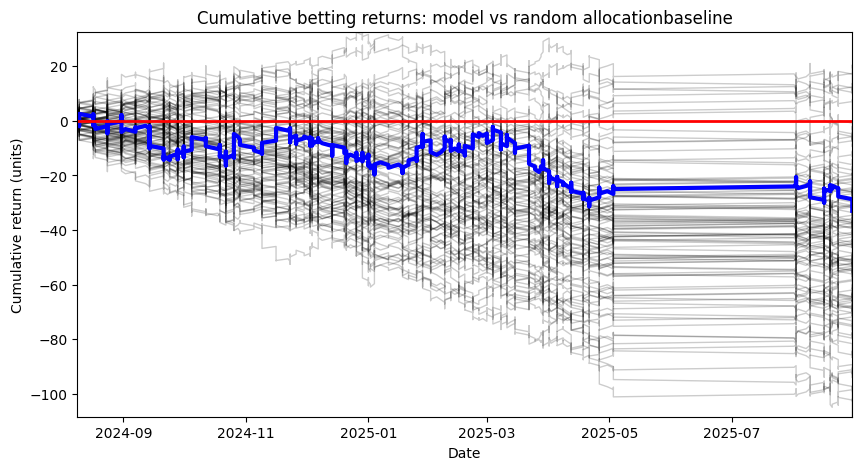

In [5]:
# Creating a dataframe of values bets
value_bets = betting_df.copy()
value_bets = value_bets.loc[(value_bets["over_bet"] == True) | (value_bets["under_bet"] == True)]
value_bets['total_goals'] = value_bets['home_goals'] + value_bets['away_goals']

# Calculating the return potential of all value bets
over_wins  = value_bets["total_goals"] >= 3
under_wins = value_bets["total_goals"] <= 2
over_return = np.where(over_wins, value_bets["Avg>2.5"] -1.0, -1.0)
under_return = np.where(under_wins, value_bets["Avg<2.5"] -1.0, -1.0)

# Calculating the returns based of the winners and losers from the model's bets
value_bets["return"] = (np.where(value_bets["over_bet"],  over_return,  0.0) + np.where(value_bets["under_bet"], under_return, 0.0))

# Making sure the matches are ordered by time
value_bets["start"] = pd.to_datetime(value_bets["start"], errors="coerce")
value_bets = value_bets.sort_values("start").reset_index(drop=True)

# Calculating the proportion of all games over/under 2.5
p_over =(betting_df["total_goals"] >= 3).mean()
p_under = (betting_df["total_goals"] <= 2).mean()

# Cumualarive model returns
model_cum = value_bets["return"].cumsum().to_numpy()

# 100 simulations for the random allocation baseline model
n_sims = 100
rng = np.random.default_rng(42)
N = len(value_bets)
over_payoff  = over_return.astype(float) # list of over returns
under_payoff = under_return.astype(float) # list of under returns
rand_cum_paths = np.empty((n_sims, N), dtype=float) # storage for simulation paths
n_over = int(round(p_over * N))  # number of simulation assignments bet on over 2.5

# Loop through the simulations
for s in range(n_sims):

    # Random assignment of over and under bets in proportions
    over_idx = rng.choice(N, size=n_over, replace=False)
    choose_over = np.zeros(N, dtype=bool)
    choose_over[over_idx] = True
    rand_returns = np.where(choose_over, over_payoff, under_payoff)
    rand_cum_paths[s] = np.cumsum(rand_returns)

# Calculating how much better/worse the model it the baseline
model_total = model_cum[-1]
rand_totals = rand_cum_paths[:, -1]
baseline_mean = rand_totals.mean()
improvement_pct = 100 * (model_total - baseline_mean) / abs(baseline_mean)

print(f"Total return over all games is: {value_bets['return'].sum():.2f}")
print(f"Model is {improvement_pct:.2f}% better than baseline mean return.")
plt.figure(figsize=(10, 5))
for s in range(n_sims):
    plt.plot(value_bets["start"], rand_cum_paths[s], linewidth=1, color="black", alpha=0.2)
plt.plot(value_bets["start"], model_cum, linewidth=3, color = "blue")
plt.axhline(y=0, linestyle="-", linewidth=2, color="red")
plt.margins(x=0, y=0)
plt.xlabel("Date")
plt.ylabel("Cumulative return (units)")
plt.title("Cumulative betting returns: model vs random allocationbaseline")
plt.show()
